In [84]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
from torchvision import models

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
from torchsummary import summary

# Custom DataSet

Напишем кастомный датасет. Для этого мы **унаследуемся от родительского класса torch.utils.data.Dataset**

Необходимо загрузить данные, затем инвертировать их в канал RGB, далее сделать для всех фото 1 размер, нормализовать фото, сделать аугментацию.

In [77]:
# для кастомного датасета важно поределить 2 функции
# __len__ для получения длины даатсета
# __getitem__ для получения индексов из датасета


# path_dir1 - путь к первой папке с фото
# path_dir2 - путь ко второй папке с фото
class Dataset2class(torch.utils.data.Dataset):
    def __init__(self, path_dir1:str, path_dir2:str):
        super().__init__()
        
        self.path_dir1 = path_dir1
        self.path_dir2 = path_dir2
        # сначала получим список файлов из папки с помощью os.listdir
        self.dir1_list = sorted(os.listdir(path_dir1))
        self.dir2_list = sorted(os.listdir(path_dir2))
        # очень важно отсортировать, чтобы порядок был один и с индексацией не было проблем
        
        
    def __len__(self):
        return len(self.dir1_list) + len(self.dir2_list)
    
    
    def __getitem__(self, idx):
        
        if idx < len(self.dir1_list):
            class_id = 0
            img_path = os.path.join(self.path_dir1, self.dir1_list[idx])
        else:
            class_id = 1
            idx -= len(self.dir1_list)
            img_path = os.path.join(self.path_dir2, self.dir2_list[idx])
        
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32)
        img = img / 255.0 # нормализация
        # интерполяция необходима, чтобы подкорректировать изображения при обрезке
        img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA)
        
        # перевод numpy в тензор
        img = img.transpose((2, 0, 1))
        t_img = torch.from_numpy(img)
        t_class_id = torch.tensor(class_id)
        
       
            
        return {'img': t_img, 'label': t_class_id}


In [78]:
train_dogs_path = r'C:\Users\alex\Project\PyTorch\CatDog\dogs_vs_cats\train\dogs'
train_cats_path = r'C:\Users\alex\Project\PyTorch\CatDog\dogs_vs_cats\train\cats'

test_dogs_path = r'C:\Users\alex\Project\PyTorch\CatDog\dogs_vs_cats\test\dogs'
test_cats_path = r'C:\Users\alex\Project\PyTorch\CatDog\dogs_vs_cats\test\cats'


train_ds_catdog = Dataset2class(train_dogs_path, train_cats_path)
test_ds_catdog = Dataset2class(test_dogs_path, test_cats_path)

**По умолчанию cv2 работает с BGR форматом. Инвертировать его в RGB можно например так  [:,:,::-1]** Либо сразу в датасете менять каналы. Что скорее всего сейчас и сделаем с помощью **cv2.cvColor(img, cv2.COLOR_BGR2RGB)**

# DataLoader

Укажем загрузчик данных

In [79]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(
    train_ds_catdog, shuffle=True, 
    batch_size=batch_size, drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    train_ds_catdog, shuffle=True,
    batch_size=batch_size, drop_last=False
)

# Визуализация данных

In [80]:
for sample in train_loader:
    img = sample['img']
    label = sample['label']
    break

In [81]:
img[0].squeeze(0).shape

torch.Size([3, 128, 128])

**Транспонируем оси для imshow**

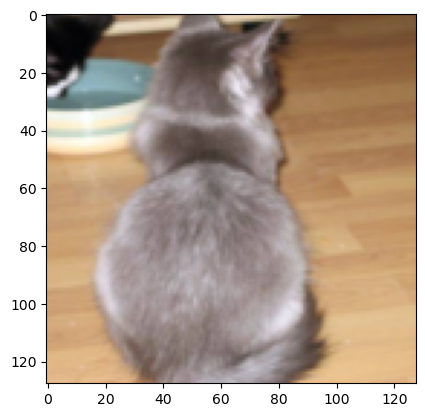

In [82]:
plt.imshow(img[0].permute(1, 2, 0))

**0 - собака, 1 - кошка**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


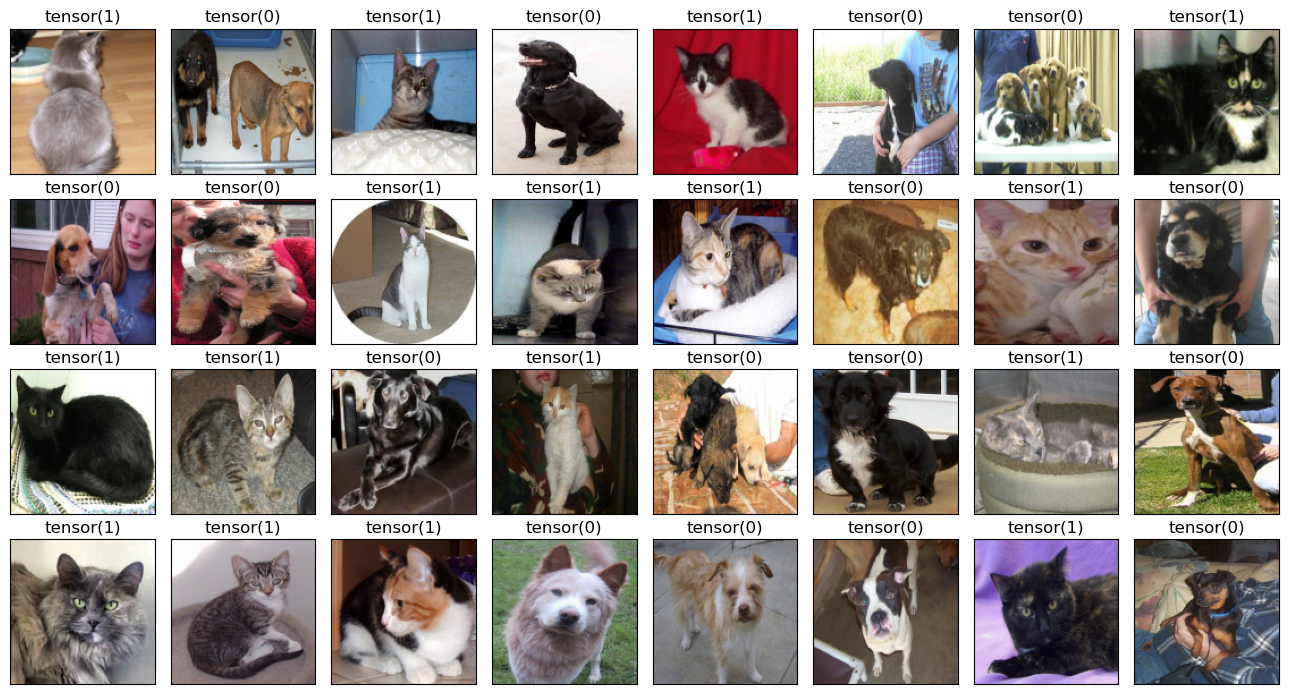

In [83]:
f, a = plt.subplots(nrows=4, ncols=8, figsize=(13, 7),
                   subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(img[i].permute(1, 2, 0))
    ax.set_title(label[i])
    
plt.tight_layout()
plt.show()

# Transfer Learning ResNet50

В данном проекте применим технологию Transfer Learning на ResNet50. 

**Название архитектуры ResNet** - это сокращение от residual network**(остаточная сеть)**

**Главная особенность ResNet** заключается **в использовании Shortcut Connections — дополнительные связи внутри сети, которые позволяют избежать проблемы затухающего градиента.** 

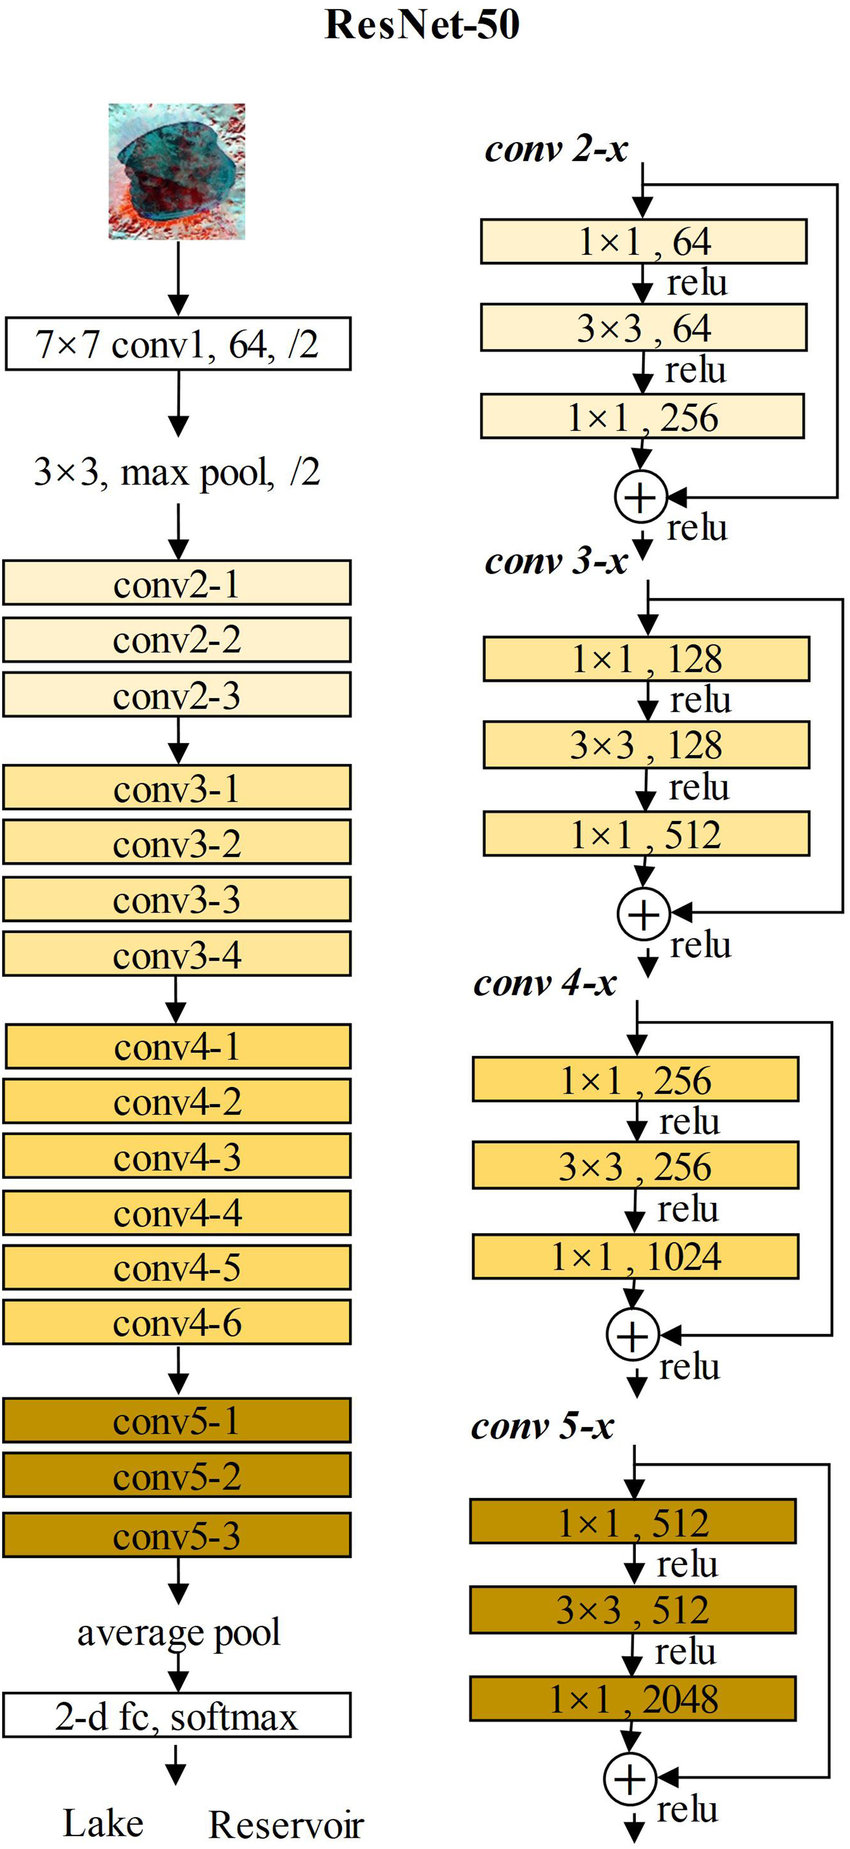

**Загрузим веса для модели**

In [85]:
model = models.resnet50(pretrained=True)

C:\ProgramData\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\alex/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:26<00:00, 3.85MB/s]


**Установим requires_grad = False, чтобы применить FineTuning** и не вычислять заново градиенты

In [86]:
for param in model.parameters():
    param.requires_grad = False

In [88]:
num_ftrs = model.fc.in_features
num_ftrs

2048

In [89]:
model.fc = nn.Linear(num_ftrs, 2)

**Посмотрим архитектуру и количество весов для тренировки**

In [90]:
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

In [91]:
for sample in test_loader:
    img = sample['img']
    label = sample['label']
    model(img)
    break

Батч из 32 элементов, 3 канала, размер 128 на 128

In [92]:
img.shape

torch.Size([64, 3, 128, 128])

# Оптимизатор и функция потерь + метрика

In [94]:
loss_fn = nn.CrossEntropyLoss()

In [103]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [96]:
def accuracy(pred, label):
    answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1) 
    return answer.mean()

**узнаем количество параметров**

In [97]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [98]:
count_parameters(model)

4098

# Обучение модели

In [105]:
epochs = 5

for epoch in range(epochs):
    loss_val = 0
    acc_val = 0
    model.train()
    for sample in tqdm(train_loader):
        img, label = sample['img'], sample['label']
        optimizer.zero_grad()
        
        label = F.one_hot(label, 2).float()
        pred = model(img)
        
        loss = loss_fn(pred, label)
        
        loss.backward()
        loss_item = loss.item()
        loss_val += loss_item
        
        optimizer.step()
                
        acc_current = accuracy(pred, label)
        acc_val += acc_current
    print(loss_val / len(train_loader))
    print('Accuracy', acc_val / len(train_loader))
                                           
                                           
                                           

  0%|          | 0/312 [00:00<?, ?it/s]C:\Users\alex\AppData\Local\Temp\ipykernel_4336\156703249.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1)
100%|██████████| 312/312 [09:10<00:00,  1.76s/it]


635.1869287062914
Accuracy 0.5225861378205128


100%|██████████| 312/312 [09:33<00:00,  1.84s/it]


20.65264309063936
Accuracy 0.7607171474358975


100%|██████████| 312/312 [09:27<00:00,  1.82s/it]


9.898289010692865
Accuracy 0.854667467948718


100%|██████████| 312/312 [09:35<00:00,  1.84s/it]


6.595408500673679
Accuracy 0.8857672275641025


100%|██████████| 312/312 [09:30<00:00,  1.83s/it]

4.7345839709592745
Accuracy 0.9053986378205128


Попробуем провалидироваться. Напомню, что **на валидации градиент нам считать не нужно!!!**

# Проверка качества на новых данныХ

In [106]:
loss_val = 0
acc_val = 0
for sample in tqdm(test_loader):
    model.eval()
    with torch.no_grad():
        img, label = sample['img'], sample['label']
        
        label = F.one_hot(label, 2).float()
        pred = model(img)
        
        loss = loss_fn(pred, label)
        
        loss_item = loss.item()
        loss_val += loss_item
        
                
        acc_current = accuracy(pred, label)
        acc_val += acc_current
print(loss_val / len(test_loader))
print('Accuracy', acc_val / len(test_loader))
                                           
                                           
                                           

  0%|          | 0/313 [00:00<?, ?it/s]C:\Users\alex\AppData\Local\Temp\ipykernel_4336\156703249.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1)
100%|██████████| 313/313 [08:50<00:00,  1.69s/it]

3.7287896301525945
Accuracy 0.9140375399361023


# Выводы

Таким образом, обучив модель всего на 5 эпохах, удалось получить метрику accuracy > 91%. **Увеличив количество эпох можно добиться намного лучшего результата!**